<a href="https://colab.research.google.com/github/dominiksakic/NETworkingMay/blob/main/20_stacked_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-05-25 03:46:35--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.129.80, 52.217.230.64, 3.5.20.45, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.129.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  45.7MB/s    in 0.3s    

2025-05-25 03:46:35 (45.7 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

temperature = np.zeros((len(lines), ))
raw_data = np.zeros((len(lines), len(header) - 1))

for idx, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[idx] = values [1]
  raw_data[idx, :] = values[:]

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

# prepare the data
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

# Normalize data, only on the train_samples NO DATA LEAKAGE
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)


In [9]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(16, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 229s 273ms/step - loss: 66.7363 - mae: 6.2542 - val_loss: 12.3801 - val_mae: 2.6233
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 216s 263ms/step - loss: 19.3158 - mae: 3.3532 - val_loss: 9.3881 - val_mae: 2.3610
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 223s 271ms/step - loss: 17.3852 - mae: 3.1995 - val_loss: 9.5780 - val_mae: 2.3959
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 216s 263ms/step - loss: 16.5778 - mae: 3.1223 - val_loss: 9.1003 - val_mae: 2.3426
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 214s 261ms/step - loss: 15.8368 - mae: 3.0549 - val_loss: 8.8898 - val_mae: 2.3145
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 216s 264ms/step - loss: 15.2043 - mae: 2.9966 - val_loss: 8.9098 - val_mae: 2.3032
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 215s 263ms/step - loss: 15.0058 - mae: 2.9801 - val_loss: 8.6655 - val_mae: 2.2741
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 217s 265ms/step - loss: 14.5457 - mae: 2.9360 - val_loss: 8.6452 - val_mae: 2.2762
Epoch 9/50
819/

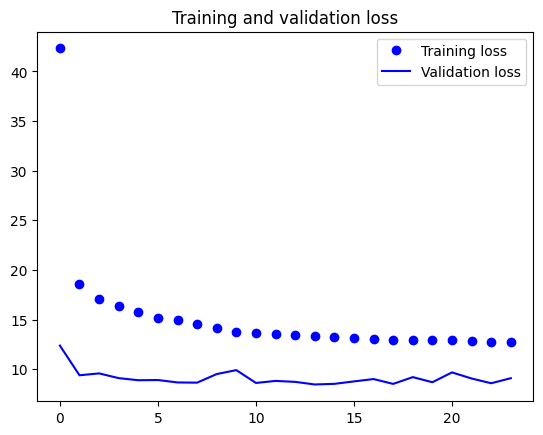

In [10]:
history = history.history
loss = history["loss"]
val_loss = history["val_loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

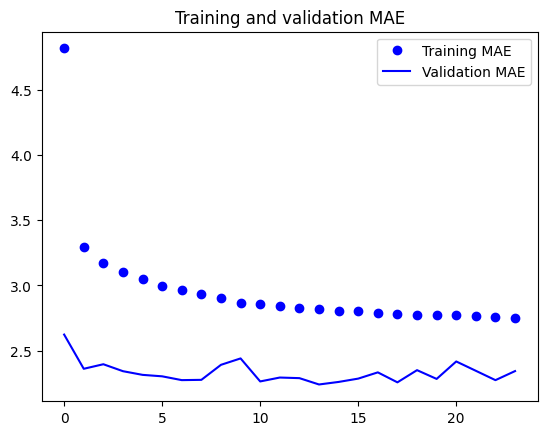

In [11]:
mae = history["mae"]
val_mae = history["val_mae"]
plt.figure()
plt.plot(epochs, mae, "bo", label="Training MAE")
plt.plot(epochs, val_mae, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [12]:
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
#Test MAE old: 2.46
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - loss: 9.6784 - mae: 2.4182
Test MAE: 2.42
